# Hello and welcome to our morphogen code!                                             

First, we are going to import some Python libraries. Libraries are collection of ready-made codes and modules that perform useful functions that made coding much simpler.

In [ ]:
pip install numpy
pip install matplotlib

In [2]:
# import Python libraries
import numpy as np # numpy is a scientific computing library
import matplotlib.pyplot as plt # matplotlib is a library for visualising results - usually through graphs/ plots

In [1]:
# setting plotting parameters
plt.rcParams['figure.figsize'] = [10, 6]
# fontsizes=[20,22,24]
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

NameError: name 'plt' is not defined

Next, we are going to define a function that takes inputs of the morphogen kinetic parameters, and numerically finds then outputs the steady state solution of the morphogen reaction-diffusion equation.


$ \frac{\partial C}{\partial t} = D \frac{\partial^2 C}{\partial x^2} - k C + v(x)$

In [6]:
# define a function to solve the reaction-diffusion equation
# Dirichlet C=0 at x=0, Neumann BC dC/dx = 0 at x=Lj
def Solve(D, k, C0, Nx, tMax, L, thresholdSS): 
    # D is the diffusion coefficient, k is the degradation rate, v is the production rate, Nx is the number of spatial (x) points, tMax is the maximum time
    # L is the tissue size, sRatio is the fraction of the tissue that is source cells
    # Finally, thresholdSS defines the maximum fractional change in concentration per unit time that the code checks to determine whether we have reached steady state (SS)
    
    dx = L/(Nx - 1) # the spatial step
    # dt = 0.5 * (1 / (((2 * D) / (dx ** 2)) + k))
    dt = (1 / (((4 * D) / (dx ** 2)) + k)) # dt is found from a stability condition called von Neumann
    Nt = round((tMax / dt) + 1) # the maximum number of time points

    D *= dt / (dx ** 2) # find diffusion prefactor
    k *= dt # find degradation rate prefactor

    concPrev = np.zeros(Nx) # the concentration at the previous timestep
    concPrev[0] = C0
    tCount = 0
    flag = 0
    while flag == 0 and tCount < Nt:
        tCount += 1
        # print(tCount)
        concCurr = np.zeros(Nx) # initiate new array of concCurr

        concCurr[1:Nx - 1] = concPrev[1:Nx - 1] * (1 - k) + D*(concPrev[2:Nx] + concPrev[0:Nx - 2] - 2* concPrev[1:Nx - 1] )
        # boundary conditions - set dC/dx to 0 at the 0th index and (N-1)th index
        concCurr[0] = C0
        concCurr[Nx - 1] = concPrev[Nx - 1] * (1 - k) + D*(concPrev[Nx - 2] - concPrev[Nx - 1] )
        # check threshold for steady state
        dC = sum(abs(concCurr - concPrev)) / sum(concCurr)
        if dC < thresholdSS:
            flag = 1
            print("Steady state has been reached")
        # set the previous solution as the current solution ready for the loop
        concPrev = np.array(concCurr)

    return concCurr # return the final concentration

In [5]:
# define a function to solve the reaction-diffusion equation - Neumann BCs flux = 0 at x and L
def Solve_Flux(D, k, v, Nx, tMax, L, sRatio, thresholdSS): 
    # D is the diffusion coefficient, k is the degradation rate, v is the production rate, Nx is the number of spatial (x) points, tMax is the maximum time
    # L is the tissue size, sRatio is the fraction of the tissue that is source cells
    # Finally, thresholdSS defines the maximum fractional change in concentration per unit time that the code checks to determine whether we have reached steady state (SS)
    
    dx = L/(Nx - 1) # the spatial step
    w = round((L * sRatio)/dx)+1 # w is the index for the edge of the source
    # dt = 0.5 * (1 / (((2 * D) / (dx ** 2)) + k))
    dt = (1 / (((4 * D) / (dx ** 2)) + k)) # dt is found from a stability condition called von Neumann
    Nt = round((tMax / dt) + 1) # the maximum number of time points

    D *= dt / (dx ** 2) # find diffusion prefactor
    k *= dt # find degradation rate prefactor
    v *= dt # find production rate prefactor

    concPrev = np.zeros(Nx) # the concentration at the previous timestep
    tCount = 0
    flag = 0
    while flag == 0 and tCount < Nt:
        tCount += 1
        # print(tCount)
        concCurr = np.zeros(Nx) # initiate new array of concCurr

        # solve the equation in the source
        concCurr[1:w] = concPrev[1:w] * (1 - k) + v + D*(concPrev[0:w-1] + concPrev[2:w+1] -2* concPrev[1:w] )
        # solve the equation out of the source
        concCurr[w:Nx - 1] = concPrev[w:Nx - 1] * (1 - k) + D*(concPrev[w+1:Nx] + concPrev[w-1:Nx - 2] - 2* concPrev[w:Nx - 1] )
        # boundary conditions - set dC/dx to 0 at the 0th index and (N-1)th index
        concCurr[0] = concPrev[0] * (1 - k) + v + D * (concPrev[1] - concPrev[0] )
        concCurr[Nx - 1] = concPrev[Nx - 1] * (1 - k) + D*(concPrev[Nx - 2] - concPrev[Nx - 1] )
        # check threshold for steady state
        dC = sum(abs(concCurr - concPrev)) / sum(concCurr)
        if dC < thresholdSS:
            flag = 1
            print("Steady state has been reached")
        # set the previous solution as the current solution ready for the loop
        concPrev = np.array(concCurr)

    return concCurr # return the final concentration

In [4]:
# define parameters
D = 3 # diffusion coefficient
k = 0.1 # degradation rate
C0 = 100 # production rate
L = 100 # tissue size
Nx = 201 # number of grid points
tMax = 10000 # maximum time to ruNx simulation
thresholdSS = 1E-08 # threshold for steady state

Steady state has been reached


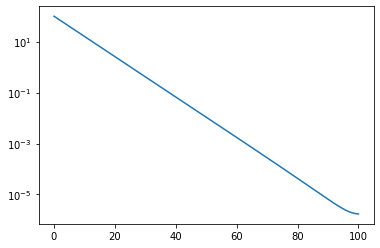

In [9]:
concCurr = Solve(D, k, C0, Nx, tMax, L, sRatio, thresholdSS)
x = np.linspace(0,L,Nx)
plt.plot(x,concCurr)
plt.yscale('log')

In [ ]:
# define function to solve
def SolveDegPower(D, k, v, Nx, tMax, L, sRatio, thresholdSS, degPower = 1):
    dx = L/(Nx - 1) # space step
    w = round(L * sRatio/dx)+1 # the index for the edge of the source
    # dt = 0.5 * (1 / (((2 * D) / (dx ** 2)) + k))
    m = 2/(degPower-1)
    A = (m*(m+1)*D/k)**(1/(degPower-1))
    x_b = (m*A*D/v)**((degPower-1)/(degPower+1))
    C_max = A/(x_b**m)
    dt = (1 / (((4 * D) / (dx ** 2)) + k*degPower*C_max))
    Nt = round((tMax / dt) + 1)

    D *= dt / (dx ** 2) # find diffusion prefactor
    k *= dt # find degradation rate prefactor
    v *= dt # find production rate prefactor

    concPrev = np.zeros(Nx)
    tCount = 0
    flag = 0
    while flag == 0 and tCount < Nt:
        tCount += 1
        concCurr = np.zeros(Nx) # initiate new array of concCurr
        # in source
        concCurr[1:w] = concPrev[1:w] - k*(concPrev[1:w]**degPower) + v + D*(concPrev[0:w-1] + concPrev[2:w+1] -2* concPrev[1:w] )
        # out of source
        concCurr[w:Nx - 1] = concPrev[w:Nx - 1] - k*(concPrev[w:Nx - 1]**degPower) + D*(concPrev[w+1:Nx] + concPrev[w-1:Nx - 2] - 2* concPrev[w:Nx - 1] )
        # boundary conditions - set dC/dx to 0 at the 0th index and (N-1)th index
        concCurr[0] = concPrev[0] - k*(concPrev[0]**degPower) + v + D * (concPrev[1] - concPrev[0] )
        concCurr[Nx - 1] = concPrev[Nx - 1] - k*(concPrev[Nx - 1]**degPower) + D*(concPrev[Nx - 2] - concPrev[Nx - 1] )
        # check threshold for steady state
        dC = sum(abs(concCurr - concPrev)) / sum(concCurr)
        if dC < thresholdSS:
            flag = 1
            print("Steady state has been reached")
        # set the previous solution as the current solution ready for the loop
        concPrev = np.array(concCurr)

    return concCurr # return the final concentration

In [ ]:
concCurr = Solve(D, k, v, Nx, tMax, L, sRatio, thresholdSS)
concCurr_1 = SolveDegPower(D, k, v, Nx, tMax, L, sRatio, thresholdSS, degPower = 2)

Steady state has been reached
Steady state has been reached


In [ ]:
def extractConcThresholds(Nx,conc,fractions=[0.25,0.5,0.75]):
    index_fractions = [int(Nx*i) for i in fractions]
    return conc[index_fractions]

def extractPositionThresholds(Nx,L,sRatio,conc,concThresholds):
    x = np.linspace(0,L,Nx)
    backwards_x = np.flip(x)
    backwards_conc = np.flip(conc)
    sourceSize = sRatio*L
    positionThresholds = np.zeros(len(concThresholds))
    for i in range(len(concThresholds)):
        post_index = np.searchsorted(backwards_conc,concThresholds[i])
        if post_index == Nx: # if C_thr > than even C[0]
            positionThresholds[i] = 0
        elif post_index == 0:
            positionThresholds[i] = L
        else:
            concStep = backwards_conc[post_index] - backwards_conc[post_index - 1] # difference in concentration
            xStep = backwards_x[post_index - 1]- backwards_x[post_index]
            concError = backwards_conc[post_index] - concThresholds[i] # the error in concentration from the index before the threshold, the overshoot
            xError = xStep*concError/concStep
            positionThresholds[i] = backwards_x[post_index] + xError

    return positionThresholds

In [ ]:
concThresholds = extractConcThresholds(Nx,concCurr)
positionThresholds = extractPositionThresholds(Nx,L,sRatio,concCurr,concThresholds)
positionThresholds

array([25., 50., 75.])

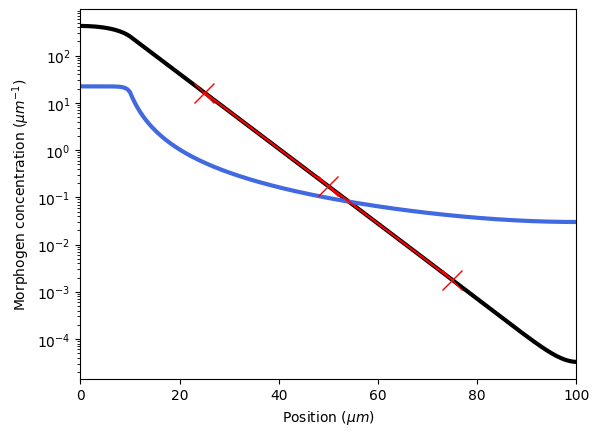

In [ ]:
# solve and plot
x = np.linspace(0,L,Nx)
plt.plot(x,concCurr,color='black',linewidth='3')
plt.plot(x,concCurr_1,color='royalblue',linewidth='3')

plt.xlabel('Position ($\mu m$)')
plt.ylabel('Morphogen concentration ($\mu m^{-1}$)')
plt.xlim(0,L)
# plt.ylim(ymax=1.05*max(concCurr))
plt.plot(positionThresholds,concThresholds,marker='x',markersize='15',color='red')
plt.yscale('log')

In [ ]:
# different morphogen production rates for exponential case
# define reference concentration thresholds
vRef = 10
concRef = Solve(D, k, vRef, Nx, tMax, L, sRatio, thresholdSS)
concThresholds = extractConcThresholds(Nx,concRef)
positionThresholdsRef = extractPositionThresholds(Nx,L,sRatio,concRef,concThresholds)
vValues = vRef*np.array([0.5,1,2,4])
positionThresholdsArray_v = np.zeros([len(vValues),len(concThresholds)])
errorPositionArray_v = np.zeros([len(vValues),len(concThresholds)])
for i in range(len(vValues)):
    conc = Solve(D, k, vValues[i], Nx, tMax, L, sRatio, thresholdSS)
    positionThresholdsCurr = extractPositionThresholds(Nx,L,sRatio,conc,concThresholds)
    positionThresholdsArray_v[i,:] = positionThresholdsCurr
    errorPositionArray_v[i,:] = positionThresholdsCurr - positionThresholdsRef

print(errorPositionArray_v)
# print(positionThresholdsArray[:])

Steady state has been reached
Steady state has been reached
Steady state has been reached
Steady state has been reached
Steady state has been reached
[[-3.79226097 -3.79049538 -3.77088044]
 [ 0.          0.          0.        ]
 [ 3.8031994   3.80055818  3.77543332]
 [ 7.5989113   7.5920691   7.53496196]]


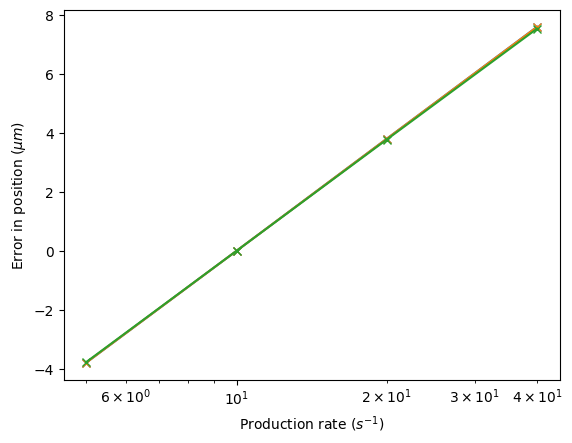

In [ ]:
colors = ['red','green','blue']
for i in range(len(concThresholds)):
    plt.plot(vValues,(errorPositionArray_v[:,i]),marker='x')
plt.xlabel('Production rate ($s^{-1}$)')
plt.ylabel('Error in position ($\mu m$)')
plt.xscale('log')

Text(0, 0.5, 'Error in position')

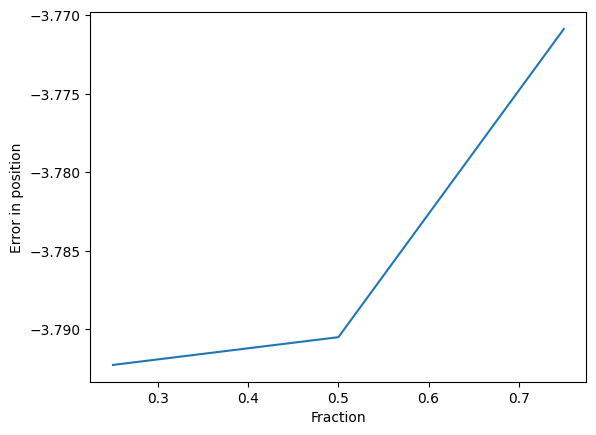

In [ ]:
plt.plot([0.25,0.5,0.75],errorPositionArray_v[0,:])
plt.xlabel('Fraction')
plt.ylabel('Error in position')
# plt.yscale('log')

In [ ]:
# different morphogen production rates for exponential case
# define reference concentration thresholds
vRef = 10
concRef = SolveDegPower(D, k, vRef, Nx, tMax, L, sRatio, thresholdSS, degPower = 2)
concThresholds = extractConcThresholds(Nx,concRef)
positionThresholdsRef = extractPositionThresholds(Nx,L,sRatio,concRef,concThresholds)
# vValues = vRef*np.array([0.25,1,4,64])
positionThresholdsArrayDegPower_v = np.zeros([len(vValues),len(concThresholds)])
errorPositionArrayDegPower_v = np.zeros([len(vValues),len(concThresholds)])
for i in range(len(vValues)):
    conc = SolveDegPower(D, k, vValues[i], Nx, tMax, L, sRatio, thresholdSS, degPower = 2)
    positionThresholdsCurr = extractPositionThresholds(Nx,L,sRatio,conc,concThresholds)
    positionThresholdsArrayDegPower_v[i,:] = positionThresholdsCurr
    errorPositionArrayDegPower_v[i,:] = positionThresholdsCurr - positionThresholdsRef

print(errorPositionArrayDegPower_v)
# print(positionThresholdsArray[:])

Steady state has been reached
Steady state has been reached
Steady state has been reached
Steady state has been reached
Steady state has been reached
[[-0.98401357 -0.98836938 -1.11750342]
 [ 0.          0.          0.        ]
 [ 0.83263732  0.83245955  0.93221726]
 [ 1.52649248  1.52802541  1.69377661]]


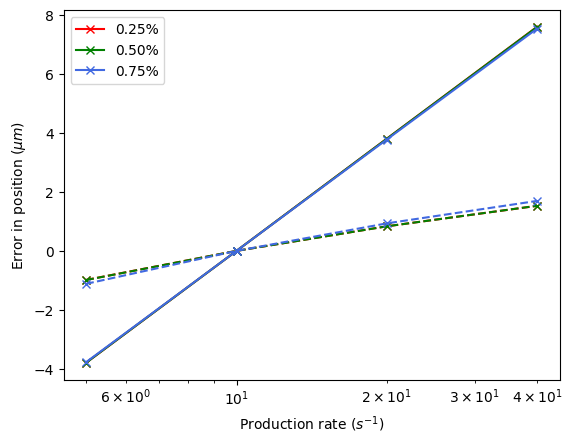

In [ ]:
colours = ['red','green','royalblue','orange']
fractions=[0.25,0.5,0.75]
for i in range(len(concThresholds)):
    plt.plot(vValues,(errorPositionArray_v[:,i]),marker='x',color=colours[i],label=f'{fractions[i]:.2f}%')
    plt.plot(vValues,(errorPositionArrayDegPower_v[:,i]),marker='x',color=colours[i],linestyle='--')

plt.xlabel('Production rate ($s^{-1}$)')
plt.ylabel('Error in position ($\mu m$)')
plt.xscale('log')
plt.legend()

In [ ]:
# scaling (vary L)
LRef = 100
concRef = Solve(D, k, v, Nx, tMax, LRef, sRatio, thresholdSS)
concThresholds = extractConcThresholds(Nx,concRef)
normPositionThresholdsRef = extractPositionThresholds(Nx,L,sRatio,concRef,concThresholds)/LRef
LValues = LRef*np.array([0.5,1,2,4])
normPositionThresholdsArray_L = np.zeros([len(LValues),len(concThresholds)])
errorPositionArray_L = np.zeros([len(LValues),len(concThresholds)])
concArray = np.zeros([len(LValues),Nx])
for i in range(len(LValues)):
    conc = Solve(D, k, v, Nx, tMax, LValues[i], sRatio, thresholdSS)
    concArray[i,:] = conc
    normPositionThresholdsCurr = extractPositionThresholds(Nx,LValues[i],sRatio,conc,concThresholds)/LValues[i]
    normPositionThresholdsArray_L[i,:] = normPositionThresholdsCurr
    errorPositionArray_L[i,:] = normPositionThresholdsCurr - normPositionThresholdsRef

print(errorPositionArray_L)

Steady state has been reached
Steady state has been reached
Steady state has been reached
Steady state has been reached
Steady state has been reached
[[ 0.1325046   0.39704529  0.25      ]
 [ 0.          0.          0.        ]
 [-0.07306433 -0.19791608 -0.32257439]
 [-0.1102894  -0.29728535 -0.48446424]]


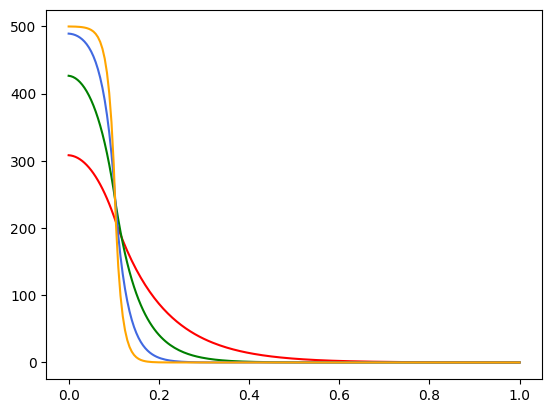

In [ ]:
r = np.linspace(0,1,Nx)
for i in range(len(LValues)):
    plt.plot(r,concArray[i,:],color=colours[i])

In [ ]:
# scaling (vary L)
LRef = 100
concRef = Solve(D, k, v, Nx, tMax, LRef, sRatio, thresholdSS)
concThresholds = extractConcThresholds(Nx,concRef)
normPositionThresholdsRef = extractPositionThresholds(Nx,L,sRatio,concRef,concThresholds)/LRef
LValues = LRef*np.array([0.5,1,2,4])
normPositionThresholdsArray_L = np.zeros([len(LValues),len(concThresholds)])
errorPositionArray_L = np.zeros([len(LValues),len(concThresholds)])
concArray = np.zeros([len(LValues),Nx])
for i in range(len(LValues)):
    conc = Solve(D, k*((LRef/LValues[i])**2), v, Nx, tMax, LValues[i], sRatio, thresholdSS)
    concArray[i,:] = conc
    normPositionThresholdsCurr = extractPositionThresholds(Nx,LValues[i],sRatio,conc,concThresholds)/LValues[i]
    normPositionThresholdsArray_L[i,:] = normPositionThresholdsCurr
    errorPositionArray_L[i,:] = normPositionThresholdsCurr - normPositionThresholdsRef

print(errorPositionArray_L)

Steady state has been reached
Steady state has been reached
Steady state has been reached
Steady state has been reached
Steady state has been reached
[[-0.07592079 -0.07589282 -0.07556488]
 [ 0.          0.          0.        ]
 [ 0.07598911  0.07592069  0.07534962]
 [ 0.15195539  0.1517439   0.15124837]]


Text(0.5, 0, 'Position ($\\mu m$)')

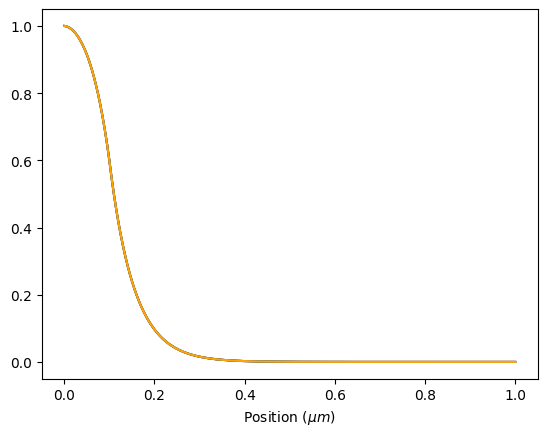

In [ ]:
r = np.linspace(0,1,Nx)
for i in range(len(LValues)):
    plt.plot(r,concArray[i,:]/max(concArray[i,:]),color=colours[i])

plt.xlabel('Position ($\mu m$)')

In [ ]:
# scaling (vary L)
LRef = 100
concRef = SolveDegPower(D, k, v, Nx, tMax, LRef, sRatio, thresholdSS,degPower=2)
concThresholds = extractConcThresholds(Nx,concRef)
normPositionThresholdsRef = extractPositionThresholds(Nx,L,sRatio,concRef,concThresholds)/LRef
LValues = LRef*np.array([0.5,1,2,4])
normPositionThresholdsArrayDegPower_L = np.zeros([len(LValues),len(concThresholds)])
errorPositionArrayDegPower_L = np.zeros([len(LValues),len(concThresholds)])
concArray = np.zeros([len(LValues),Nx])
for i in range(len(LValues)):
    conc = SolveDegPower(D, k, v, Nx, tMax, LValues[i], sRatio, thresholdSS, degPower=2)
    concArray[i,:] = conc
    normPositionThresholdsDegPowerCurr = extractPositionThresholds(Nx,LValues[i],sRatio,conc,concThresholds)/LValues[i]
    normPositionThresholdsArrayDegPower_L[i,:] = normPositionThresholdsCurr
    errorPositionArrayDegPower_L[i,:] = normPositionThresholdsCurr - normPositionThresholdsRef

print(errorPositionArrayDegPower_L)

23.207944168063893
Steady state has been reached
23.207944168063893
Steady state has been reached
23.207944168063893
Steady state has been reached
23.207944168063893
Steady state has been reached
23.207944168063893
Steady state has been reached
[[0.15195539 0.1517439  0.15124837]
 [0.15195539 0.1517439  0.15124837]
 [0.15195539 0.1517439  0.15124837]
 [0.15195539 0.1517439  0.15124837]]


22.334012890330765
22.36062781102895
22.360679774533487
22.360679774997894


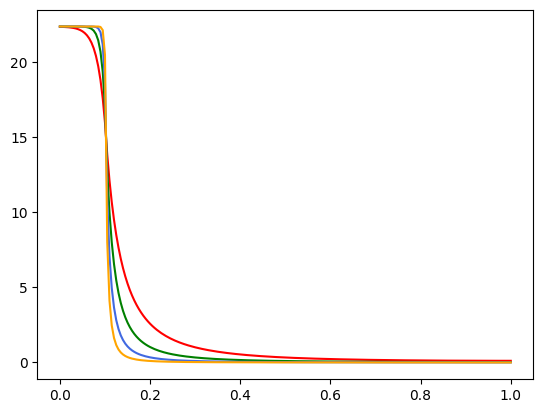

In [ ]:
r = np.linspace(0,1,Nx)
for i in range(len(LValues)):
    plt.plot(r,concArray[i,:],color=colours[i])